In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product
pd.set_option("display.max_colwidth", 10000)

tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":5,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
    'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
    "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4cm":"g",
          "4em":"g",
          "donor":"#a4e0ef", 
          "host":"#ff7f0e",
         "WT":"#02feff",
         "Young CHIM":"#008080",
         "Old CHIM":"white",
         "TH.DP1": 'k',
          'LN.4nai':'k',
          'LN.4em':'k',
          'LN.4cm':'k',
          "4cm.Fast":"#1f77b4",
          "4em.Fast":"#1f77b4",
          "4cm.Slow":"#1f77b4",
          "4em.Slow":"#1f77b4",
         }

Y = mpatches.Patch(color="#008080", label='Young CHIM')
O = mpatches.Patch(color="white", label='Old CHIM')

my_marks = {"donor": "o", 
           "host": "X",
         "WT":"o",
         "Young CHIM":"P",
         "Old CHIM":"^"}

scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':"k",
                
}

def myMAP(data):
    
#     data=data[~np.isnan(data)]
#     counts, x = np.histogram(data,bins=(np.int(np.rint(np.sqrt(len(data))))))
#     x_ind = np.unravel_index(np.argmax(counts), counts.shape)

#     return x[x_ind]
    data=data[~np.isnan(data)]
    arrayed = data.to_numpy()
    if arrayed[0]==-1:
        y=-1
    elif arrayed[0]==-10:
        y=-10
    else:
        nparam_density = sts.kde.gaussian_kde(arrayed)
        x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
        nparam_density = nparam_density(x)
        y=x[np.argsort(nparam_density)[-1]]
    return y

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #golden_ratio = (5**.5 - 1) / 2
    golden_ratio = 1

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

#loading dataframes for parameters and data

df = pd.read_excel('/home/elise/Code/BRDU/UPDATED master doc.xlsx', sheet_name='fraction donor',index_col='mouse.ID')

#only ucl mice, excluding outliers and before donor cells have entered perpheriy (21days)
df=df[(df['expt.location']=='UCL')&(df['time.post.BMT'] > 22)&(df['TH.DP1'] > 0.5)]
df['age_cat']=np.where(df['expt.ID'].str.contains("TH205"), 'Old CHIM', np.where(df['expt.ID'].str.contains("TH259"), 'Young CHIM', 'WT'))

In [2]:
#%%
youngfile = '/opt/mesh/tiree/elise/samples_1/youngmice_r17/stan-cache-'
oldfile = '/opt/mesh/tiree/elise/samples_1/oldmice_r25/stan-cache-'

parnames = ["Source_D","fd"] 

# parnames = ["alpha_A","alpha_B","delta_A","delta_B","beta","Source","mu","eff","gamma"] 
# pretty_parnames = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","Source","$\\mu$","$\\epsilon$","$\\gamma$"] #

donorhost = pd.read_csv('/home/elise/Code/BRDU/donorhost.csv')

donorhost['Age'] = donorhost['Age'].replace('Young','Young CHIM')
donorhost['Age'] = donorhost['Age'].replace('Old','Old CHIM')

pardf = pd.DataFrame()

ADHc = ['host','donor','all']
populationc = ['4cm','4em']
agec = ['Young CHIM','Old CHIM']

for idx, adhpop in enumerated_product(ADHc,populationc, agec):
    fl = []
    fb = []
    
    #data slicing and manulipulation
    if adhpop[2]=='Young CHIM':
        location = youngfile+adhpop[1]+adhpop[0]+'_1/'
    else:
        location = oldfile+adhpop[1]+adhpop[0]+'_1/'

    sys.path.insert(1, location)
    import paras
    reload(paras)

    for f_name in os.listdir(location):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(location+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(location+f_name)

    sam_fb = cmdstanpy.from_csv(fb)
    sam_fl = cmdstanpy.from_csv(fl)
            
    sam_dhl = cmdstanpy.from_csv(donorhost.loc[(donorhost.Pop==adhpop[1])&(donorhost.Age==adhpop[2])&(donorhost.Type=='linear'),"File"].to_string(index=False))
    sam_dhb = cmdstanpy.from_csv(donorhost.loc[(donorhost.Pop==adhpop[1])&(donorhost.Age==adhpop[2])&(donorhost.Type=='branched'),"File"].to_string(index=False))


    parests_flvl = [sam_dhl.stan_variable(pn) for pn in parnames]
    parests_fbvl = [sam_dhb.stan_variable(pn) for pn in parnames]

    k_hat_fl =  sam_fl.stan_variable("k_hat")
    k_hat_fb =  sam_fb.stan_variable("k_hat")

    pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames)
    pardf_lvl['type']='linear'
    pardf_lvl['population']=paras.populationc
    pardf_lvl['doh']=paras.ADHc
    pardf_lvl['popdoh']=paras.populationc+paras.ADHc
    pardf_lvl['ones']=1
    pardf_lvl['age']=adhpop[2]
    pardf_lvl['FastSlowRatio']=np.mean(np.sum(k_hat_fl[:len(parests_flvl[0]),:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fl[:len(parests_flvl[0]),:,paras.switch:],axis=2), axis=1)
    pardf_lvl['FastFraction']=np.mean(np.sum(k_hat_fl[:len(parests_flvl[0]),:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fl[:len(parests_flvl[0]),:,:],axis=2), axis=1)
    pardf_lvl['fastcount']=np.median(np.sum(k_hat_fl[:len(parests_flvl[0]),:,0:paras.switch],axis=2), axis=1)
    pardf_lvl['slowcount']=np.median(np.sum(k_hat_fl[:len(parests_flvl[0]),:,paras.switch:],axis=2), axis=1)
    pardf_lvl['totalcount']=np.median(np.sum(k_hat_fl[:len(parests_flvl[0]),:,:],axis=2), axis=1)
    if adhpop[0]=='donor':
        pardf_lvl['Source']=pardf_lvl["Source_D"]*pardf_lvl["fd"]
    else:
        pardf_lvl['Source']=pardf_lvl["Source_D"]*(1-pardf_lvl["fd"])
        
    pardf_bvl=pd.DataFrame(np.transpose(parests_fbvl), columns = parnames)
    pardf_bvl['type']='branched'
    pardf_bvl['population']=paras.populationc
    pardf_bvl['doh']=paras.ADHc
    pardf_bvl['popdoh']=paras.populationc+paras.ADHc
    pardf_bvl['ones']=1
    pardf_bvl['age']=adhpop[2]
    pardf_bvl['FastSlowRatio']=np.mean(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,paras.switch:],axis=2), axis=1)
    pardf_bvl['FastFraction']=np.mean(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,:],axis=2), axis=1)
    pardf_bvl['fastcount']=np.median(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,0:paras.switch],axis=2), axis=1)
    pardf_bvl['slowcount']=np.median(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,paras.switch:],axis=2), axis=1)
    pardf_bvl['totalcount']=np.median(np.sum(k_hat_fb[:len(parests_fbvl[0]),:,:],axis=2), axis=1)
    if adhpop[0]=='donor':
        pardf_bvl['Source']=pardf_bvl["Source_D"]*pardf_bvl["fd"]
    else:
        pardf_bvl['Source']=pardf_bvl["Source_D"]*(1-pardf_bvl["fd"])

    pardf = pd.concat([pardf,pardf_lvl, pardf_bvl])
#     pardf = pd.concat([pardf, pardf_bvl])

populationc = ['4cm','4em']
agec = ['Young CHIM','Old CHIM']
typec = ['branched','linear']

for idx, adhpop in enumerated_product(populationc, agec, typec):

    pardf.loc[(pardf['population']==adhpop[0])
              &(pardf['type']==adhpop[2])
              &(pardf['age']==adhpop[1]),"chimera"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&
                                                            (pardf['type']==adhpop[2])&
                                                            (pardf['age']==adhpop[1])&
                                                            (pardf['population']==adhpop[0])].Source/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&
                                                                                                            (pardf['type']==adhpop[2])&
                                                                                                            (pardf['age']==adhpop[1])].Source+pardf[(pardf['popdoh']==adhpop[0]+'host')
                                                                                                                                                    &(pardf['type']==adhpop[2])
                                                                                                                                                    &(pardf['age']==adhpop[1])].Source)
    if adhpop[0]=='4cm':
        
        pardf.loc[(pardf['population']==adhpop[0])&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1]),"4cm.Fast"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount+pardf[(pardf['popdoh']==adhpop[0]+'host')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount)

        pardf.loc[(pardf['population']==adhpop[0])&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1]),"4cm.Slow"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount+pardf[(pardf['popdoh']==adhpop[0]+'host')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount)
    else:
 
        pardf.loc[(pardf['population']==adhpop[0])&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1]),"4em.Fast"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount+pardf[(pardf['popdoh']==adhpop[0]+'host')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].fastcount)

        pardf.loc[(pardf['population']==adhpop[0])&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1]),"4em.Slow"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount+pardf[(pardf['popdoh']==adhpop[0]+'host')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].slowcount)
        
    pardf.loc[(pardf['population']==adhpop[0])&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1]),"bulkchimera"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].totalcount/(pardf[(pardf['popdoh']==adhpop[0]+'donor')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].totalcount+pardf[(pardf['popdoh']==adhpop[0]+'host')&(pardf['type']==adhpop[2])&(pardf['age']==adhpop[1])].totalcount)


pardf_copy=pardf.copy()

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='TH.DP1'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] =-1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4nai'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4cm'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4em'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'



pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='TH.DP1'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] =-1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4nai'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4cm'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4em'
pardf_copy.at[len(pardf_copy)-1,'type']='linear'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='TH.DP1'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] =-1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4nai'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4cm'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4em'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Young CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'



pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='TH.DP1'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] =-1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4nai'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4cm'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

pardf_copy.loc[len(pardf_copy)] = -1
pardf_copy.at[len(pardf_copy)-1,'population']='LN.4em'
pardf_copy.at[len(pardf_copy)-1,'type']='branched'
pardf_copy.at[len(pardf_copy)-1,'age']='Old CHIM'
pardf_copy.at[len(pardf_copy)-1,'doh']='donor'

linearrealyoung-20230911134243_2.csv
branchedrealyoung-20230911134243_4.csv
branchedrealyoung-20230911134243_2.csv
linearrealyoung-20230911134243_4.csv
linearrealyoung-20230911134243_1.csv
branchedrealyoung-20230911134243_5.csv
branchedrealyoung-20230911134243_1.csv
linearrealyoung-20230911134243_3.csv
branchedrealyoung-20230911134243_3.csv
linearrealyoung-20230911134243_5.csv
linearrealold-20230912111553_5.csv
branchedrealold-20230912111553_3.csv
branchedrealold-20230912111553_2.csv
linearrealold-20230912111553_4.csv
branchedrealold-20230912111553_4.csv
linearrealold-20230912111553_2.csv
linearrealold-20230912111553_3.csv
linearrealold-20230912111553_1.csv
branchedrealold-20230912111553_1.csv
branchedrealold-20230912111553_5.csv
linearrealyoung-20230911134243_2.csv
linearrealyoung-20230911134243_4.csv
branchedrealyoung-20230911134313_4.csv
linearrealyoung-20230911134243_1.csv
branchedrealyoung-20230911134313_2.csv
branchedrealyoung-20230911134313_1.csv
linearrealyoung-20230911134243_3

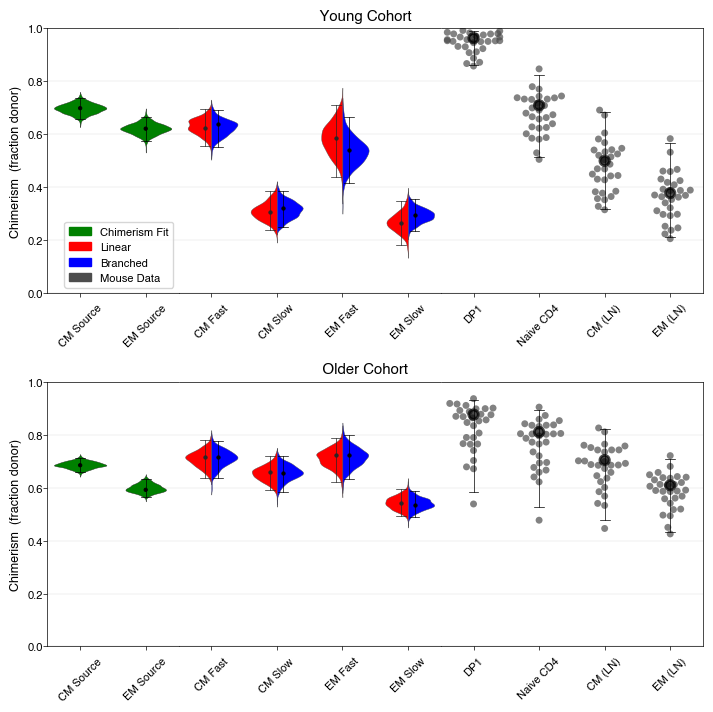

In [3]:

fig = plt.figure(figsize=(7.2,7.2), tight_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2,height_ratios=[1, 1], width_ratios = [1,1])



type_i = 'branched'


#******************************************************************************************************************
# Chimerism
#******************************************************************************************************************

subspec = spec[0,:].subgridspec(ncols=3, nrows=1,wspace=0,width_ratios = [0.5,1,1])
ax = fig.add_subplot(subspec[0])


age_i = 'Young CHIM'


parsliced = pardf_copy[(pardf_copy['doh'] == 'donor')&(pardf_copy['age'] == age_i)]


parsliced2 = parsliced[['population','chimera',]].copy()


parsliced2 = parsliced2.melt(['population'], var_name='category', value_name='values')


parsliced2 = parsliced2.dropna(subset='values')

my_pal = {"4cm":"g",
          "4em":"g",
        "linear":"g",
          "branched":"g",
         "TH.DP1": '0.3',
          'LN.4nai':'0.3',
          'LN.4em':'0.3',
          'LN.4cm':'0.3',
          "4cm.Fast":"#7d81fc",
          "4em.Fast":"#7d81fc",
          "4cm.Slow":"#7d81fc",
          "4em.Slow":"#7d81fc",
         }



scatterkwags = {"palette": my_pal,
                  'edgecolor':'k',
                 "linewidth":0
                
}


pointplotkwags = {"data":parsliced2,
                  "x":"population",
                  "dodge":0.2, 
                  "join":False, 
#                   "palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":0.35,
                  
                 }

violinplotkwags = {"data":parsliced2,
                   "x":"population",
                   "saturation":1, 
                   "inner":None,
                   "palette":my_pal,
                   "linewidth":0.3,
                   "split":True
                  }


sns.violinplot(y='values',ax=ax, **violinplotkwags,order=['4cm','4em'])
sns.pointplot(y='values',ax=ax, **pointplotkwags,order=['4cm','4em'])
ax.set_ylabel('Chimerism  (fraction donor)')
ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(['CM Source', 'EM Source'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['right'].set_visible(False)

d = mpatches.Patch(color="r", label='Linear')
h = mpatches.Patch(color="b", label='Branched')
g = mpatches.Patch(color="g", label='Chimerism Fit')
t = mpatches.Patch(color="0.3", label='Mouse Data')
ax.legend(handles=[g,d,h,t],loc="lower right")

#*********************************************************************
ax = fig.add_subplot(subspec[1])
parsliced = pardf_copy[(pardf_copy['doh'] == 'donor')&(pardf_copy['age'] == age_i)]


parsliced2 = parsliced[['population','type', '4cm.Fast','4cm.Slow', '4em.Fast','4em.Slow']].copy()


parsliced2 = parsliced2.melt(['population','type'], var_name='category', value_name='values')

parsliced2.loc[(parsliced2['population']=='TH.DP1'),"category"] = 'TH.DP1'
parsliced2.loc[(parsliced2['population']=='LN.4nai'),"category"] = 'LN.4nai'
parsliced2.loc[(parsliced2['population']=='LN.4cm'),"category"] = 'LN.4cm'
parsliced2.loc[(parsliced2['population']=='LN.4em'),"category"] = 'LN.4em'

parsliced2.loc[(parsliced2['population']=='4em')&(parsliced2['category']=='4em.Fast'),"population"] = '4em.Fast'
parsliced2.loc[(parsliced2['population']=='4em')&(parsliced2['category']=='4em.Slow'),"population"] = '4em.Slow'

parsliced2.loc[(parsliced2['population']=='4cm')&(parsliced2['category']=='4cm.Fast'),"population"] = '4cm.Fast'
parsliced2.loc[(parsliced2['population']=='4cm')&(parsliced2['category']=='4cm.Slow'),"population"] = '4cm.Slow'

parsliced2 = parsliced2.dropna(subset='values')

my_pal = {"4cm":"g",
          "4em":"g",
        "linear":"r",
          "branched":"b",
         "TH.DP1": '0.3',
          'LN.4nai':'0.3',
          'LN.4em':'0.3',
          'LN.4cm':'0.3',
          "4cm.Fast":"#7d81fc",
          "4em.Fast":"#7d81fc",
          "4cm.Slow":"#7d81fc",
          "4em.Slow":"#7d81fc",
         }



scatterkwags = {"palette": my_pal,
                  'edgecolor':'k',
                 "linewidth":0
                
}


pointplotkwags = {"data":parsliced2,
                  "x":"population",
                  "hue":"type",
                  "dodge":0.2, 
                  "join":False, 
#                   "palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":0.35,
                  
                 }

violinplotkwags = {"data":parsliced2,
                   "x":"population",
                    "hue":"type",
                   "saturation":1, 
                   "inner":None,
                   "palette":my_pal,
                   "linewidth":0.3,
                   "split":True
                  }


sns.violinplot(y='values',ax=ax, **violinplotkwags,order=['4cm.Fast', '4cm.Slow', '4em.Fast', '4em.Slow'],legend=False)
sns.pointplot(y='values',ax=ax, **pointplotkwags,order=['4cm.Fast', '4cm.Slow', '4em.Fast', '4em.Slow'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(left=False)
ax.set_ylim([0,1])
ax.set_title('                           Young Cohort')
ax.get_legend().remove()
ax.set_xticklabels([ 'CM Fast','CM Slow', 'EM Fast','EM Slow'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#***************************************************************
ax = fig.add_subplot(subspec[2])
parsliced = df[(df['age_cat'] == age_i)]

parsliced2 = parsliced[['expt.location','TH.DP1','LN.4nai','LN.4cm','LN.4em']].copy()

parsliced2 = parsliced2.melt(['expt.location'], var_name='category', value_name='values')

parsliced2_copy=parsliced2.copy()

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm.Slow'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em.Slow'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm.Fast'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em.Fast'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

pointplotkwags ={                  "dodge":0.2, 
                  "join":False, 
                  #"palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":1}

sns.swarmplot(zorder=1,data=parsliced2_copy, x="category", y="values",ax=ax, 
              order=['TH.DP1','LN.4nai','LN.4cm','LN.4em'],
             **scatterkwags)
sns.pointplot(data=parsliced2_copy, x="category", y="values",ax=ax, 
              order=['TH.DP1','LN.4nai','LN.4cm','LN.4em'],**pointplotkwags)
ax.set_yticklabels('')
ax.tick_params(left=False)
ax.set_ylim([0,1])

ax.set_xlabel('')
ax.set_ylabel('')
plt.setp(ax.collections, alpha=.7)
ax.set_xticklabels(['DP1','Naive CD4','CM (LN)','EM (LN)'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['left'].set_visible(False)

#******************************************************************************************************************
subspec = spec[1,:].subgridspec(ncols=3, nrows=1,wspace=0,width_ratios = [0.5,1,1])
ax = fig.add_subplot(subspec[0])


age_i = 'Old CHIM'


parsliced = pardf_copy[(pardf_copy['doh'] == 'donor')&(pardf_copy['age'] == age_i)]


parsliced2 = parsliced[['population','chimera',]].copy()


parsliced2 = parsliced2.melt(['population'], var_name='category', value_name='values')


parsliced2 = parsliced2.dropna(subset='values')

my_pal = {"4cm":"g",
          "4em":"g",
        "linear":"g",
          "branched":"g",
         "TH.DP1": '0.3',
          'LN.4nai':'0.3',
          'LN.4em':'0.3',
          'LN.4cm':'0.3',
          "4cm.Fast":"#7d81fc",
          "4em.Fast":"#7d81fc",
          "4cm.Slow":"#7d81fc",
          "4em.Slow":"#7d81fc",
         }



scatterkwags = {"palette": my_pal,
                  'edgecolor':'k',
                 "linewidth":0
                
}


pointplotkwags = {"data":parsliced2,
                  "x":"population",
                  "dodge":0.2, 
                  "join":False, 
#                   "palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":0.35,
                  
                 }

violinplotkwags = {"data":parsliced2,
                   "x":"population",
                   "saturation":1, 
                   "inner":None,
                   "palette":my_pal,
                   "linewidth":0.3,
                   "split":True
                  }


sns.violinplot(y='values',ax=ax, **violinplotkwags,order=['4cm','4em'])
sns.pointplot(y='values',ax=ax, **pointplotkwags,order=['4cm','4em'])
ax.set_ylabel('Chimerism  (fraction donor)')
ax.set_ylim([0,1])
ax.set_xlabel('')
ax.set_xticklabels(['CM Source', 'EM Source'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['right'].set_visible(False)


#*********************************************************************
ax = fig.add_subplot(subspec[1])
parsliced = pardf_copy[(pardf_copy['doh'] == 'donor')&(pardf_copy['age'] == age_i)]


parsliced2 = parsliced[['population','type', '4cm.Fast','4cm.Slow', '4em.Fast','4em.Slow']].copy()


parsliced2 = parsliced2.melt(['population','type'], var_name='category', value_name='values')

parsliced2.loc[(parsliced2['population']=='TH.DP1'),"category"] = 'TH.DP1'
parsliced2.loc[(parsliced2['population']=='LN.4nai'),"category"] = 'LN.4nai'
parsliced2.loc[(parsliced2['population']=='LN.4cm'),"category"] = 'LN.4cm'
parsliced2.loc[(parsliced2['population']=='LN.4em'),"category"] = 'LN.4em'

parsliced2.loc[(parsliced2['population']=='4em')&(parsliced2['category']=='4em.Fast'),"population"] = '4em.Fast'
parsliced2.loc[(parsliced2['population']=='4em')&(parsliced2['category']=='4em.Slow'),"population"] = '4em.Slow'

parsliced2.loc[(parsliced2['population']=='4cm')&(parsliced2['category']=='4cm.Fast'),"population"] = '4cm.Fast'
parsliced2.loc[(parsliced2['population']=='4cm')&(parsliced2['category']=='4cm.Slow'),"population"] = '4cm.Slow'

parsliced2 = parsliced2.dropna(subset='values')

my_pal = {"4cm":"g",
          "4em":"g",
        "linear":"r",
          "branched":"b",
         "TH.DP1": '0.3',
          'LN.4nai':'0.3',
          'LN.4em':'0.3',
          'LN.4cm':'0.3',
          "4cm.Fast":"#7d81fc",
          "4em.Fast":"#7d81fc",
          "4cm.Slow":"#7d81fc",
          "4em.Slow":"#7d81fc",
         }



scatterkwags = {"palette": my_pal,
                  'edgecolor':'k',
                 "linewidth":0
                
}


pointplotkwags = {"data":parsliced2,
                  "x":"population",
                  "hue":"type",
                  "dodge":0.2, 
                  "join":False, 
#                   "palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":0.35,
                  
                 }

violinplotkwags = {"data":parsliced2,
                   "x":"population",
                    "hue":"type",
                   "saturation":1, 
                   "inner":None,
                   "palette":my_pal,
                   "linewidth":0.3,
                   "split":True
                  }


sns.violinplot(y='values',ax=ax, **violinplotkwags,order=['4cm.Fast', '4cm.Slow', '4em.Fast', '4em.Slow'],legend=False)
sns.pointplot(y='values',ax=ax, **pointplotkwags,order=['4cm.Fast', '4cm.Slow', '4em.Fast', '4em.Slow'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.tick_params(left=False)
ax.set_ylim([0,1])
ax.set_title('                           Older Cohort')
ax.get_legend().remove()
ax.set_xticklabels([ 'CM Fast','CM Slow', 'EM Fast','EM Slow'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#***************************************************************
ax = fig.add_subplot(subspec[2])
parsliced = df[(df['age_cat'] == age_i)]

parsliced2 = parsliced[['expt.location','TH.DP1','LN.4nai','LN.4cm','LN.4em']].copy()

parsliced2 = parsliced2.melt(['expt.location'], var_name='category', value_name='values')

parsliced2_copy=parsliced2.copy()

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm.Slow'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em.Slow'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4cm.Fast'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']=-10

parsliced2_copy.loc[len(parsliced2_copy)] = -10
parsliced2_copy.at[len(parsliced2_copy)-1,'category']='4em.Fast'
parsliced2_copy.at[len(parsliced2_copy)-1,'values']= -10

pointplotkwags ={                  "dodge":0.2, 
                  "join":False, 
                  #"palette":my_pal, 
                  "color":"k",
                  "estimator": myMAP, 
                  "errorbar":('pi', 97.5),
                  #"ci":97.5,                  
                  "capsize":0.15,
                  "errwidth":.5,
                  "scale":1}

sns.swarmplot(zorder=1,data=parsliced2_copy, x="category", y="values",ax=ax, 
              order=['TH.DP1','LN.4nai','LN.4cm','LN.4em'],
             **scatterkwags)
sns.pointplot(data=parsliced2_copy, x="category", y="values",ax=ax, 
              order=['TH.DP1','LN.4nai','LN.4cm','LN.4em'],**pointplotkwags)
ax.set_yticklabels('')
ax.tick_params(left=False)
ax.set_ylim([0,1])

ax.set_xlabel('')
ax.set_ylabel('')
plt.setp(ax.collections, alpha=.7)
ax.set_xticklabels(['DP1','Naive CD4','CM (LN)','EM (LN)'])
ax.tick_params(axis='x',labelrotation=45)
ax.spines['left'].set_visible(False) #*************************************************************************************************************************


fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig6.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

# # fig.savefig('/home/elise/Dropbox/BrdU/Paper/Elise draft 2022/Figures/fig7png.png', dpi='figure', format='png',
# #         bbox_inches='tight', pad_inches=0.1)